# Entraînement et Évaluation d'Agents pour Othello

Ce notebook permet d'entraîner et d'évaluer deux types d'agents d'apprentissage par renforcement pour jouer à Othello :
1. Un agent MCTS (Monte Carlo Tree Search)
2. Un agent DQN (Deep Q-Network)

Ces agents seront entraînés contre un agent aléatoire, puis nous visualiserons leur performance et leur progression.

In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import random
from tqdm.notebook import tqdm
import torch
import pygame
import os
import gymnasium as gym

# Nos modules
from Env.env import OthelloEnv, BLACK, WHITE, EMPTY, BOARD_SIZE
from Agents.mcts import MCTSAgent
from Agents.mcts_parallel import MCTSAgentParallel
from Agents.dqn import DQNAgent

# Configuration du style matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme(style="darkgrid")

# Définir une graine aléatoire pour la reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1. Agent Aléatoire

Commençons par définir un agent qui joue aléatoirement parmi les coups valides. Cet agent servira de référence et d'adversaire pour l'entraînement.

In [2]:
class RandomAgent:
    def __init__(self):
        self.name = "Random"
    
    def choose_action(self, env):
        """Choisit aléatoirement une action parmi les coups valides."""
        # Récupérer les coups valides
        obs = env._get_observation()
        valid_moves = [i for i, is_valid in enumerate(obs["valid_moves"]) if is_valid == 1]
        
        # Si aucun coup valide, retourner une action par défaut
        if not valid_moves:
            return 0
        
        # Retourner un coup aléatoire
        return random.choice(valid_moves)

## 2. Fonction d'Évaluation

Créons une fonction pour évaluer nos agents en les faisant jouer contre l'agent aléatoire.

In [3]:
def evaluate_agent(agent, opponent, num_games=100, render=False):
    """Évalue un agent contre un adversaire sur plusieurs parties."""
    env = OthelloEnv()
    wins = 0
    losses = 0
    draws = 0
    total_rewards = 0
    
    for game in tqdm(range(num_games), desc=f"{agent.name} vs {opponent.name}"):
        # Réinitialiser l'environnement
        obs, _ = env.reset()
        done = False
        game_reward = 0
        
        # Jouer la partie
        while not done:
            # Déterminer quel agent joue (BLACK commence)
            current_player = obs["current_player"]
            current_agent = agent if current_player == 0 else opponent  # 0 pour BLACK, 1 pour WHITE
            
            # Choisir une action
            action = current_agent.choose_action(env)
            
            # Exécuter l'action
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Accumuler la récompense (du point de vue de l'agent évalué)
            if current_player == 0:  # Si c'est notre agent qui a joué
                game_reward += reward
        
        # Analyser le résultat
        black_count, white_count = env._get_score()
        if black_count > white_count:  # BLACK a gagné
            wins += 1
        elif white_count > black_count:  # WHITE a gagné
            losses += 1
        else:  # Match nul
            draws += 1
        
        total_rewards += game_reward
    
    # Calculer les statistiques
    win_rate = wins / num_games
    avg_reward = total_rewards / num_games
    
    return {
        "wins": wins,
        "losses": losses,
        "draws": draws,
        "win_rate": win_rate,
        "avg_reward": avg_reward
    }

## 3. Fonction de Visualisation

Créons une fonction pour visualiser une partie entre deux agents.

In [4]:
def visualize_game(agent1, agent2, delay=0.5):
    """Visualise une partie entre deux agents."""
    # Configuration de pygame
    pygame.init()
    
    # Constantes pour l'interface graphique
    SQUARE_SIZE = 60
    BOARD_WIDTH = BOARD_SIZE * SQUARE_SIZE
    INFO_PANEL_WIDTH = 300
    WINDOW_WIDTH = BOARD_WIDTH + INFO_PANEL_WIDTH
    WINDOW_HEIGHT = BOARD_WIDTH
    BACKGROUND_COLOR = (0, 120, 0)  # Vert foncé
    LINE_COLOR = (0, 0, 0)  # Noir
    BLACK_COLOR = (0, 0, 0)  # Noir
    WHITE_COLOR = (255, 255, 255)  # Blanc
    INFO_PANEL_COLOR = (50, 50, 50)  # Gris foncé
    TEXT_COLOR = (255, 255, 255)  # Blanc
    VALID_MOVE_COLOR = (0, 255, 0, 150)  # Vert semi-transparent
    
    # Création de la fenêtre
    screen = pygame.display.set_mode((WINDOW_WIDTH, WINDOW_HEIGHT))
    pygame.display.set_caption(f"{agent1.name} vs {agent2.name}")
    
    # Initialisation des polices
    title_font = pygame.font.SysFont("Arial", 30, bold=True)
    info_font = pygame.font.SysFont("Arial", 20)
    score_font = pygame.font.SysFont("Arial", 24, bold=True)
    
    # Créer une surface pour les coups valides
    valid_move_surface = pygame.Surface((SQUARE_SIZE, SQUARE_SIZE), pygame.SRCALPHA)
    valid_move_surface.fill((0, 255, 0, 100))  # Vert semi-transparent
    
    # Horloge pour contrôler la vitesse
    clock = pygame.time.Clock()
    
    # Initialiser l'environnement
    env = OthelloEnv()
    obs, _ = env.reset()
    done = False
    black_reward = 0
    white_reward = 0
    actions_history = []
    
    def draw_board():
        """Dessine le plateau de jeu."""
        # Fond du plateau
        screen.fill(BACKGROUND_COLOR, (0, 0, BOARD_WIDTH, WINDOW_HEIGHT))
        
        # Lignes du plateau
        for i in range(BOARD_SIZE + 1):
            pygame.draw.line(screen, LINE_COLOR, (i * SQUARE_SIZE, 0), 
                             (i * SQUARE_SIZE, BOARD_WIDTH), 2)
            pygame.draw.line(screen, LINE_COLOR, (0, i * SQUARE_SIZE), 
                             (BOARD_WIDTH, i * SQUARE_SIZE), 2)
        
        # Récupérer l'état actuel
        board = obs["board"]
        valid_moves_array = obs["valid_moves"]
        
        # Convertir le tableau valide_moves en liste de tuples
        valid_moves = []
        for i in range(len(valid_moves_array)):
            if valid_moves_array[i] == 1:
                row, col = i // BOARD_SIZE, i % BOARD_SIZE
                valid_moves.append((row, col))
        
        # Dessiner les mouvements valides en surbrillance
        for row, col in valid_moves:
            screen.blit(valid_move_surface, (col * SQUARE_SIZE, row * SQUARE_SIZE))
        
        # Dessiner les pièces
        for row in range(BOARD_SIZE):
            for col in range(BOARD_SIZE):
                center_x = col * SQUARE_SIZE + SQUARE_SIZE // 2
                center_y = row * SQUARE_SIZE + SQUARE_SIZE // 2
                
                if board[row][col] == BLACK:
                    pygame.draw.circle(screen, BLACK_COLOR, (center_x, center_y), 
                                      SQUARE_SIZE // 2 - 5)
                elif board[row][col] == WHITE:
                    pygame.draw.circle(screen, WHITE_COLOR, (center_x, center_y), 
                                      SQUARE_SIZE // 2 - 5)
    
    def draw_info_panel():
        """Dessine le panneau d'informations."""
        # Fond du panneau
        pygame.draw.rect(screen, INFO_PANEL_COLOR, 
                         (BOARD_WIDTH, 0, INFO_PANEL_WIDTH, WINDOW_HEIGHT))
        
        # Titre
        title = title_font.render("OTHELLO", True, TEXT_COLOR)
        screen.blit(title, (BOARD_WIDTH + INFO_PANEL_WIDTH // 2 - title.get_width() // 2, 20))
        
        # Agents
        agents_title = info_font.render(f"{agent1.name} (Noir) vs {agent2.name} (Blanc)", True, TEXT_COLOR)
        screen.blit(agents_title, (BOARD_WIDTH + INFO_PANEL_WIDTH // 2 - agents_title.get_width() // 2, 60))
        
        # Score
        black_count, white_count = env._get_score()
        
        score_title = info_font.render("SCORE", True, TEXT_COLOR)
        screen.blit(score_title, (BOARD_WIDTH + INFO_PANEL_WIDTH // 2 - score_title.get_width() // 2, 100))
        
        score_black = score_font.render(f"Noir: {black_count}", True, TEXT_COLOR)
        screen.blit(score_black, (BOARD_WIDTH + 20, 130))
        
        score_white = score_font.render(f"Blanc: {white_count}", True, TEXT_COLOR)
        screen.blit(score_white, (BOARD_WIDTH + 20, 160))
        
        # Tour du joueur
        current_player = "Noir" if obs["current_player"] == 0 else "Blanc"
        current_agent = agent1.name if obs["current_player"] == 0 else agent2.name
        player_text = info_font.render(f"Tour: {current_player} ({current_agent})", True, TEXT_COLOR)
        screen.blit(player_text, (BOARD_WIDTH + 20, 200))
        
        # Récompenses cumulatives
        reward_title = info_font.render("RÉCOMPENSES", True, TEXT_COLOR)
        screen.blit(reward_title, (BOARD_WIDTH + INFO_PANEL_WIDTH // 2 - reward_title.get_width() // 2, 240))
        
        reward_black = info_font.render(f"Noir: {black_reward:.1f}", True, TEXT_COLOR)
        screen.blit(reward_black, (BOARD_WIDTH + 20, 270))
        
        reward_white = info_font.render(f"Blanc: {white_reward:.1f}", True, TEXT_COLOR)
        screen.blit(reward_white, (BOARD_WIDTH + 20, 300))
        
        # Historique des actions
        history_title = info_font.render("DERNIÈRES ACTIONS", True, TEXT_COLOR)
        screen.blit(history_title, (BOARD_WIDTH + INFO_PANEL_WIDTH // 2 - history_title.get_width() // 2, 340))
        
        # Afficher les 5 dernières actions
        for i, (action, player) in enumerate(actions_history[-5:]):
            row, col = action // BOARD_SIZE, action % BOARD_SIZE
            player_name = "Noir" if player == 0 else "Blanc"
            action_text = info_font.render(f"{player_name}: ({row}, {col})", True, TEXT_COLOR)
            screen.blit(action_text, (BOARD_WIDTH + 20, 370 + i * 25))
        
        # Instructions
        instructions = info_font.render("Appuyez sur ESPACE pour faire avancer", True, TEXT_COLOR)
        screen.blit(instructions, (BOARD_WIDTH + INFO_PANEL_WIDTH // 2 - instructions.get_width() // 2, 490))
        
        quit_instr = info_font.render("ou Q pour quitter", True, TEXT_COLOR)
        screen.blit(quit_instr, (BOARD_WIDTH + INFO_PANEL_WIDTH // 2 - quit_instr.get_width() // 2, 520))
    
    # Boucle principale de visualisation
    running = True
    auto_play = False
    last_action_time = 0
    
    while running:
        current_time = time.time()
        
        # Gérer les événements
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:  # Quitter
                    running = False
                elif event.key == pygame.K_SPACE:  # Faire avancer manuellement
                    if not done:
                        auto_play = False
                        last_action_time = 0  # Forcer la prochaine action
                elif event.key == pygame.K_a:  # Mode automatique
                    auto_play = not auto_play
        
        # Mode automatique ou action manuelle
        if (auto_play and current_time - last_action_time > delay) or (not auto_play and last_action_time == 0):
            if not done:
                # Déterminer quel agent joue
                current_player = obs["current_player"]
                current_agent = agent1 if current_player == 0 else agent2
                
                # Choisir une action
                action = current_agent.choose_action(env)
                
                # Exécuter l'action
                next_obs, reward, terminated, truncated, info = env.step(action)
                
                # Enregistrer l'action dans l'historique
                actions_history.append((action, current_player))
                
                # Mettre à jour les récompenses
                if current_player == 0:  # BLACK
                    black_reward += reward
                else:  # WHITE
                    white_reward += reward
                
                # Mettre à jour l'état
                obs = next_obs
                done = terminated or truncated
                
                # Mettre à jour le temps de la dernière action
                last_action_time = current_time
            else:
                # Partie terminée, afficher le résultat
                black_count, white_count = env._get_score()
                if black_count > white_count:
                    print(f"Noir ({agent1.name}) a gagné! {black_count}-{white_count}")
                elif white_count > black_count:
                    print(f"Blanc ({agent2.name}) a gagné! {white_count}-{black_count}")
                else:
                    print(f"Match nul! {black_count}-{white_count}")
                
                # Attendre un peu avant de fermer
                if auto_play:
                    time.sleep(3)
                    running = False
        
        # Dessiner le jeu
        draw_board()
        draw_info_panel()
        
        # Mettre à jour l'affichage
        pygame.display.flip()
        
        # Limiter la fréquence d'images
        clock.tick(60)
    
    # Fermer pygame
    pygame.quit()

## 4. Entraînement de l'Agent MCTS

Entraînons maintenant l'agent MCTS contre l'agent aléatoire.

In [5]:
# Création des agents
random_agent = RandomAgent()
mcts_agent = MCTSAgentParallel(num_simulations=200)  # Utiliser moins de simulations pour la démo

# Entraînement
print("Entraînement de l'agent MCTS...")
num_episodes = 50  # Réduire pour accélérer l'entraînement
env = OthelloEnv()
mcts_rewards = mcts_agent.train(env, num_episodes=num_episodes)

Entraînement de l'agent MCTS...


Entraînement MCTS_Parallel_198:  20%|██        | 10/50 [06:20<25:57, 38.94s/it]

Épisode 10/50, Récompense moyenne: 192.00


Entraînement MCTS_Parallel_198:  40%|████      | 20/50 [13:04<19:58, 39.95s/it]

Épisode 20/50, Récompense moyenne: 192.00


Entraînement MCTS_Parallel_198:  60%|██████    | 30/50 [19:49<13:32, 40.63s/it]

Épisode 30/50, Récompense moyenne: 192.00


Entraînement MCTS_Parallel_198:  80%|████████  | 40/50 [26:47<06:54, 41.44s/it]

Épisode 40/50, Récompense moyenne: 192.00


Entraînement MCTS_Parallel_198: 100%|██████████| 50/50 [33:29<00:00, 40.19s/it]

Épisode 50/50, Récompense moyenne: 192.00


## 5. Entraînement de l'Agent DQN

Entraînons maintenant l'agent DQN contre l'agent aléatoire.

In [6]:
# Création de l'agent DQN
dqn_agent = DQNAgent()
# dqn_agent.load("dqn_agent")

# Entraînement
print("Entraînement de l'agent DQN...")
num_episodes = 1000  # DQN nécessite généralement plus d'épisodes
env = OthelloEnv()
dqn_rewards, dqn_losses = dqn_agent.train(env, num_episodes=num_episodes)

Entraînement de l'agent DQN...
Épisode 10/1000, Récompense: 160.00, Perte: 326.4038, Epsilon: 0.0678
Épisode 20/1000, Récompense: 218.00, Perte: 695.7971, Epsilon: 0.0100
Épisode 30/1000, Récompense: 178.00, Perte: 89.9492, Epsilon: 0.0100
Épisode 40/1000, Récompense: 174.00, Perte: 41.1910, Epsilon: 0.0100
Épisode 50/1000, Récompense: 166.00, Perte: 26.2708, Epsilon: 0.0100
Épisode 60/1000, Récompense: 202.00, Perte: 22.1087, Epsilon: 0.0100
Épisode 70/1000, Récompense: 174.00, Perte: 18.9563, Epsilon: 0.0100
Épisode 80/1000, Récompense: 162.00, Perte: 19.2088, Epsilon: 0.0100
Épisode 90/1000, Récompense: 154.00, Perte: 17.9337, Epsilon: 0.0100
Épisode 100/1000, Récompense: 166.00, Perte: 18.3836, Epsilon: 0.0100
Épisode 110/1000, Récompense: 164.00, Perte: 20.6660, Epsilon: 0.0100
Épisode 120/1000, Récompense: 166.00, Perte: 21.0882, Epsilon: 0.0100
Épisode 130/1000, Récompense: 182.00, Perte: 25.0663, Epsilon: 0.0100
Épisode 140/1000, Récompense: 172.00, Perte: 20.1798, Epsilon: 0.0

## 6. Visualisation des Résultats d'Entraînement

Visualisons les résultats d'entraînement des deux agents.

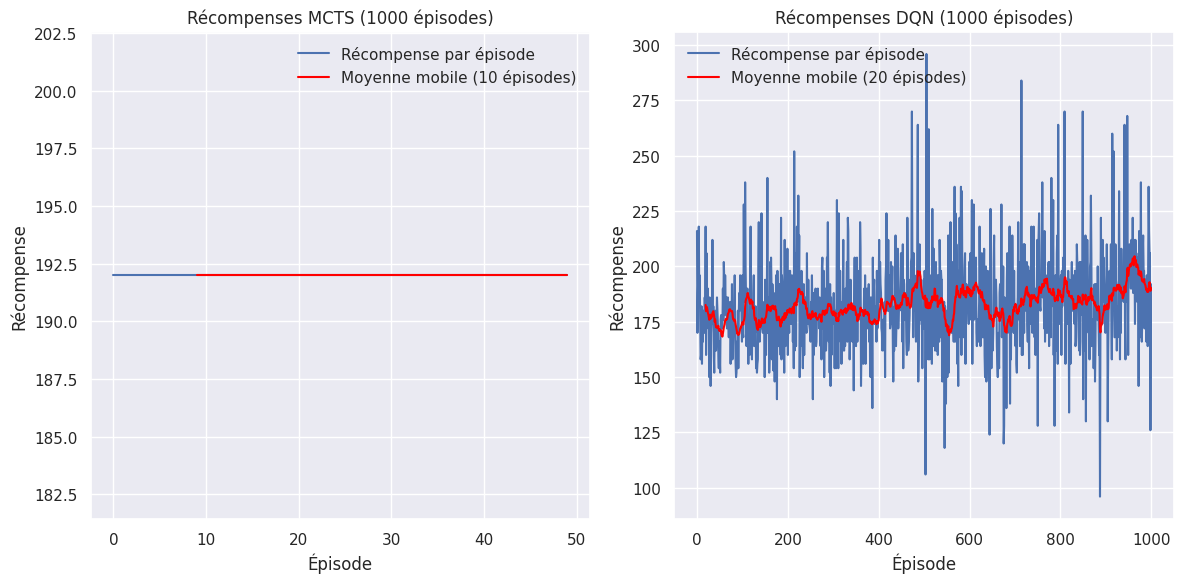

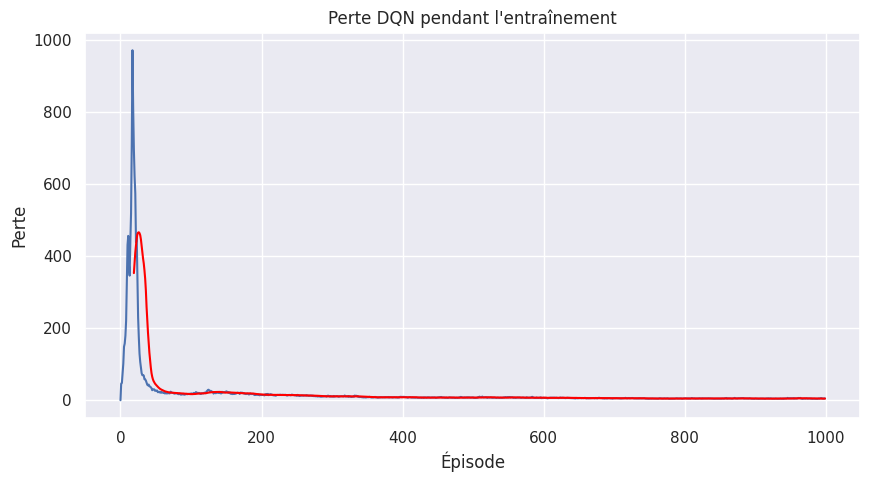

In [7]:
# Visualisation des récompenses pendant l'entraînement
plt.figure(figsize=(12, 6))

# Graphique des récompenses MCTS
plt.subplot(1, 2, 1)
plt.plot(mcts_rewards, label='Récompense par épisode')
plt.plot(pd.Series(mcts_rewards).rolling(10).mean(), label='Moyenne mobile (10 épisodes)', color='red')
plt.title(f'Récompenses MCTS ({num_episodes} épisodes)')
plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.legend()
plt.grid(True)

# Graphique des récompenses DQN
plt.subplot(1, 2, 2)
plt.plot(dqn_rewards, label='Récompense par épisode')
plt.plot(pd.Series(dqn_rewards).rolling(20).mean(), label='Moyenne mobile (20 épisodes)', color='red')
plt.title(f'Récompenses DQN ({num_episodes} épisodes)')
plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualisation des pertes DQN
plt.figure(figsize=(10, 5))
plt.plot(dqn_losses)
plt.plot(pd.Series(dqn_losses).rolling(20).mean(), color='red')
plt.title('Perte DQN pendant l\'entraînement')
plt.xlabel('Épisode')
plt.ylabel('Perte')
plt.grid(True)
plt.show()

## 7. Évaluation des Agents

Évaluons les performances des agents contre l'agent aléatoire.

In [8]:
# Évaluation de l'agent MCTS contre l'agent aléatoire
print("Évaluation de l'agent MCTS contre l'agent aléatoire...")
mcts_vs_random = evaluate_agent(mcts_agent, random_agent, num_games=50)

# Évaluation de l'agent DQN contre l'agent aléatoire
print("Évaluation de l'agent DQN contre l'agent aléatoire...")
dqn_vs_random = evaluate_agent(dqn_agent, random_agent, num_games=50)

# Comparaison directe MCTS vs DQN
print("Évaluation de l'agent MCTS contre l'agent DQN...")
mcts_vs_dqn = evaluate_agent(mcts_agent, dqn_agent, num_games=20)
print("Évaluation de l'agent DQN contre l'agent MCTS...")
dqn_vs_mcts = evaluate_agent(dqn_agent, mcts_agent, num_games=20)

Évaluation de l'agent MCTS contre l'agent aléatoire...


MCTS_Parallel_198 vs Random:   0%|          | 0/50 [00:00<?, ?it/s]

Évaluation de l'agent DQN contre l'agent aléatoire...


DQN vs Random:   0%|          | 0/50 [00:00<?, ?it/s]

Évaluation de l'agent MCTS contre l'agent DQN...


MCTS_Parallel_198 vs DQN:   0%|          | 0/20 [00:00<?, ?it/s]

Évaluation de l'agent DQN contre l'agent MCTS...


DQN vs MCTS_Parallel_198:   0%|          | 0/20 [00:00<?, ?it/s]

,Agent,Victoires,Défaites,Nuls,Taux de victoire,Récompense moyenne
0,MCTS vs Random,23,27,0,46.0%,68.50
1,DQN vs Random,12,35,3,24.0%,-108.88
2,MCTS vs DQN,20,0,0,100.0%,460.40
3,DQN vs MCTS,18,2,0,90.0%,-297.25


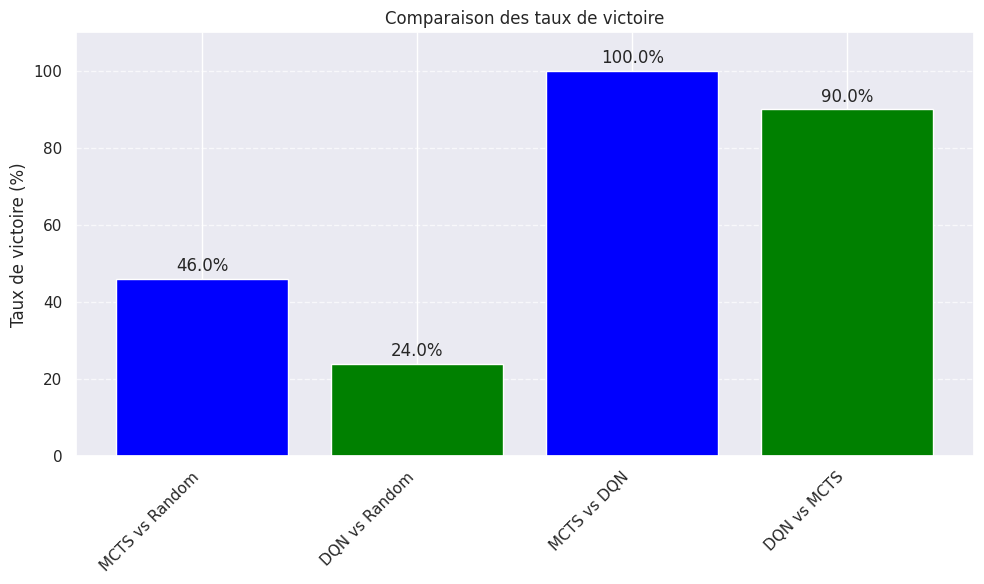

In [9]:
# Affichage des résultats sous forme de tableau
results = pd.DataFrame([
    {
        'Agent': 'MCTS vs Random',
        'Victoires': mcts_vs_random['wins'],
        'Défaites': mcts_vs_random['losses'],
        'Nuls': mcts_vs_random['draws'],
        'Taux de victoire': f"{mcts_vs_random['win_rate']*100:.1f}%",
        'Récompense moyenne': f"{mcts_vs_random['avg_reward']:.2f}"
    },
    {
        'Agent': 'DQN vs Random',
        'Victoires': dqn_vs_random['wins'],
        'Défaites': dqn_vs_random['losses'],
        'Nuls': dqn_vs_random['draws'],
        'Taux de victoire': f"{dqn_vs_random['win_rate']*100:.1f}%",
        'Récompense moyenne': f"{dqn_vs_random['avg_reward']:.2f}"
    },
    {
        'Agent': 'MCTS vs DQN',
        'Victoires': mcts_vs_dqn['wins'],
        'Défaites': mcts_vs_dqn['losses'],
        'Nuls': mcts_vs_dqn['draws'],
        'Taux de victoire': f"{mcts_vs_dqn['win_rate']*100:.1f}%",
        'Récompense moyenne': f"{mcts_vs_dqn['avg_reward']:.2f}"
    },
    {
        'Agent': 'DQN vs MCTS',
        'Victoires': dqn_vs_mcts['wins'],
        'Défaites': dqn_vs_mcts['losses'],
        'Nuls': dqn_vs_mcts['draws'],
        'Taux de victoire': f"{dqn_vs_mcts['win_rate']*100:.1f}%",
        'Récompense moyenne': f"{dqn_vs_mcts['avg_reward']:.2f}"
    }
])

# Affichage du tableau
display(results)

# Visualisation graphique des taux de victoire
plt.figure(figsize=(10, 6))
agents = results['Agent']
win_rates = [float(rate.strip('%')) for rate in results['Taux de victoire']]

# Création du graphique à barres
bars = plt.bar(agents, win_rates, color=['blue', 'green', 'blue', 'green'])
plt.ylabel('Taux de victoire (%)')
plt.title('Comparaison des taux de victoire')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', rotation=0)

plt.ylim(0, 110)  # Ajuster l'échelle pour que les étiquettes soient visibles
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

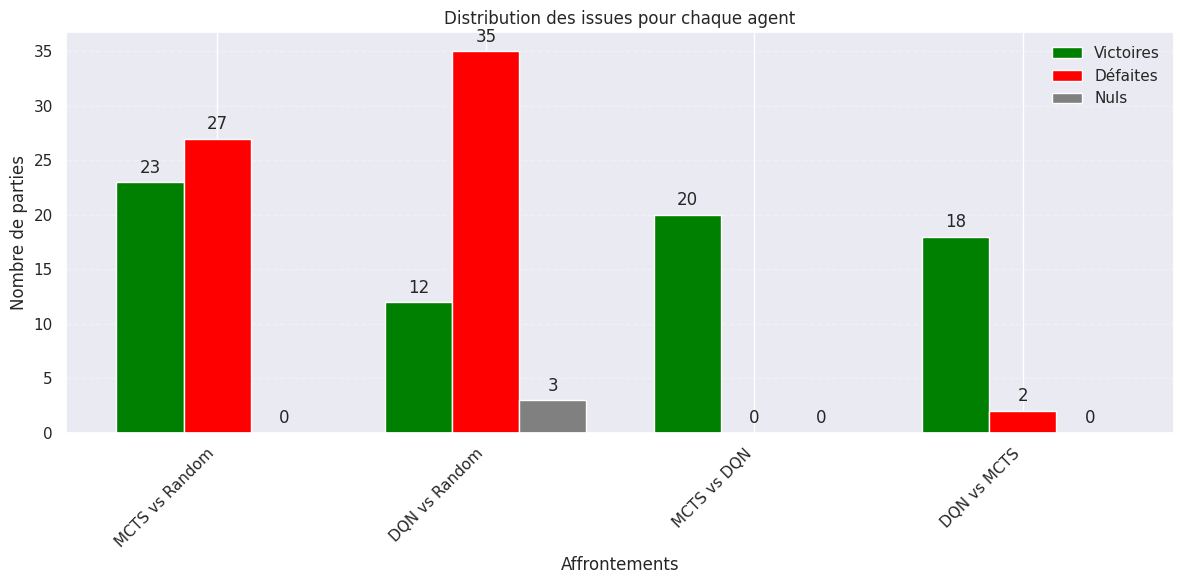

In [10]:
# Visualisation de la distribution des issues (victoires, défaites, nuls)
plt.figure(figsize=(12, 6))

# Préparation des données
agents = results['Agent']
wins = results['Victoires']
losses = results['Défaites']
draws = results['Nuls']

x = np.arange(len(agents))  # Positions des groupes de barres
width = 0.25  # Largeur des barres

# Création des barres
plt.bar(x - width, wins, width, label='Victoires', color='green')
plt.bar(x, losses, width, label='Défaites', color='red')
plt.bar(x + width, draws, width, label='Nuls', color='gray')

# Ajout des étiquettes et légendes
plt.xlabel('Affrontements')
plt.ylabel('Nombre de parties')
plt.title('Distribution des issues pour chaque agent')
plt.xticks(x, agents, rotation=45, ha='right')
plt.legend()

# Ajout des valeurs sur les barres
for i, v in enumerate(wins):
    plt.text(i - width, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(losses):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(draws):
    plt.text(i + width, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [11]:
# 8. Visualisation d'une partie
print("Visualisation d'une partie entre l'agent MCTS et l'agent aléatoire...")
print("Utilisez ESPACE pour faire avancer manuellement, A pour le mode automatique, Q pour quitter.")
visualize_game(mcts_agent, random_agent, delay=1.0)

Visualisation d'une partie entre l'agent MCTS et l'agent aléatoire...
Utilisez ESPACE pour faire avancer manuellement, A pour le mode automatique, Q pour quitter.
Blanc (Random) a gagné! 36-28


In [12]:
# Visualisation d'une partie entre l'agent DQN et l'agent aléatoire
print("Visualisation d'une partie entre l'agent DQN et l'agent aléatoire...")
print("Utilisez ESPACE pour faire avancer manuellement, A pour le mode automatique, Q pour quitter.")
visualize_game(dqn_agent, random_agent, delay=1.0)

Visualisation d'une partie entre l'agent DQN et l'agent aléatoire...
Utilisez ESPACE pour faire avancer manuellement, A pour le mode automatique, Q pour quitter.
Blanc (Random) a gagné! 42-22


In [16]:
# 9. Visualisation d'une partie entre les deux agents entraînés
print("Visualisation d'une partie entre l'agent MCTS et l'agent DQN...")
print("Utilisez ESPACE pour faire avancer manuellement, A pour le mode automatique, Q pour quitter.")
visualize_game(dqn_agent, mcts_agent, delay=1.0)

Visualisation d'une partie entre l'agent MCTS et l'agent DQN...
Utilisez ESPACE pour faire avancer manuellement, A pour le mode automatique, Q pour quitter.
Blanc (MCTS_Parallel_198) a gagné! 48-16


In [14]:
# 10. Sauvegarde des agents entraînés
print("Sauvegarde des agents entraînés...")
mcts_agent.save("mcts_agent")
dqn_agent.save("dqn_agent")
print("Agents sauvegardés avec succès!")

Sauvegarde des agents entraînés...
Agents sauvegardés avec succès!


In [15]:
# 11. Conclusion
print("Résumé des performances:")
for idx, row in results.iterrows():
    print(f"{row['Agent']}: Taux de victoire {row['Taux de victoire']}, Récompense moyenne {row['Récompense moyenne']}")

print("\nConclusion:")
if float(results.loc[0, 'Taux de victoire'].strip('%')) > float(results.loc[1, 'Taux de victoire'].strip('%')):
    print("L'agent MCTS a obtenu de meilleurs résultats contre l'agent aléatoire.")
else:
    print("L'agent DQN a obtenu de meilleurs résultats contre l'agent aléatoire.")

if mcts_vs_dqn['win_rate'] > dqn_vs_mcts['win_rate']:
    print("Dans l'affrontement direct, l'agent MCTS semble avoir l'avantage sur l'agent DQN.")
else:
    print("Dans l'affrontement direct, l'agent DQN semble avoir l'avantage sur l'agent MCTS.")

Résumé des performances:
MCTS vs Random: Taux de victoire 46.0%, Récompense moyenne 68.50
DQN vs Random: Taux de victoire 24.0%, Récompense moyenne -108.88
MCTS vs DQN: Taux de victoire 100.0%, Récompense moyenne 460.40
DQN vs MCTS: Taux de victoire 90.0%, Récompense moyenne -297.25

Conclusion:
L'agent MCTS a obtenu de meilleurs résultats contre l'agent aléatoire.
Dans l'affrontement direct, l'agent MCTS semble avoir l'avantage sur l'agent DQN.
